# Initialization

In [1]:
import sys
import pathlib
sys.path.append('../il_pedagogical')

import il_pedagogical as ilp
import il_parse as ila
import seaborn as sns

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd
pd.options.display.float_format = '{:.0f}'.format

ini_pool_size = [25, 50, 75, 100]
plt.rcParams.update({'font.size': 18})
sns.set(style="white", palette="deep", color_codes=True, font_scale=1.5)
sns.set(style="white", palette="deep", color_codes=True, font_scale=1.5)
sns.set_style("ticks")

## Distribution of apparent activation energies

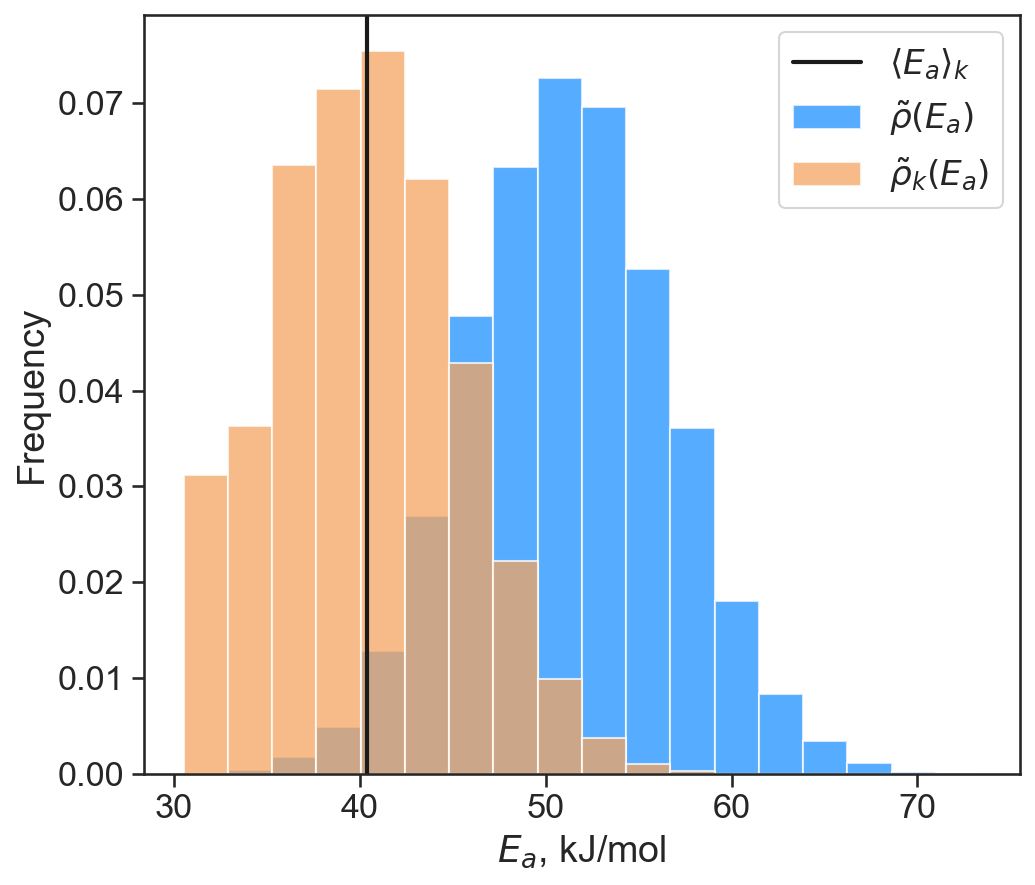

5.399087199804452

In [2]:
il_morse = ila.Parser('../logs/IL_50.json')

fig, ax1 = plt.subplots(1, 1, figsize=(7, 6), dpi=150)

T = 300
n_bins = 18
barrier_distribution = il_morse.true_barrier_heights()
site_avg_E = ilp.k_weighted_avg_activation_E(barrier_distribution, T)
y, x, _ = ax1.hist(barrier_distribution, density=True,bins=n_bins, color='dodgerblue', alpha=0.75, label=r'$\tilde{\rho}(E_a)$')
y, x, _ = ax1.hist(barrier_distribution, density=True, weights=np.exp(-(barrier_distribution*1000)/(8.314*T)), bins=n_bins, color='sandybrown', alpha=0.75, label=r'$\tilde{\rho}_k(E_a)$')

ax1.plot([site_avg_E, site_avg_E], [0, max(y) + max(y)*0.05], linewidth=2, c='k', label=r'$\langle E_a \rangle_k$')
ax1.set_ylim([0, max(y) + max(y)*0.05])
# ax1.set_xticks(ax1.get_xlabels())
plt.legend()
ax1.set_xlabel(r'$E_a$, kJ/mol')
ax1.set_ylabel('Frequency')
fig.tight_layout()
plt.savefig('f5.png', dpi=600, format='png')

plt.show()


site_avg_E
np.std(barrier_distribution)

## Fit of the initial pool

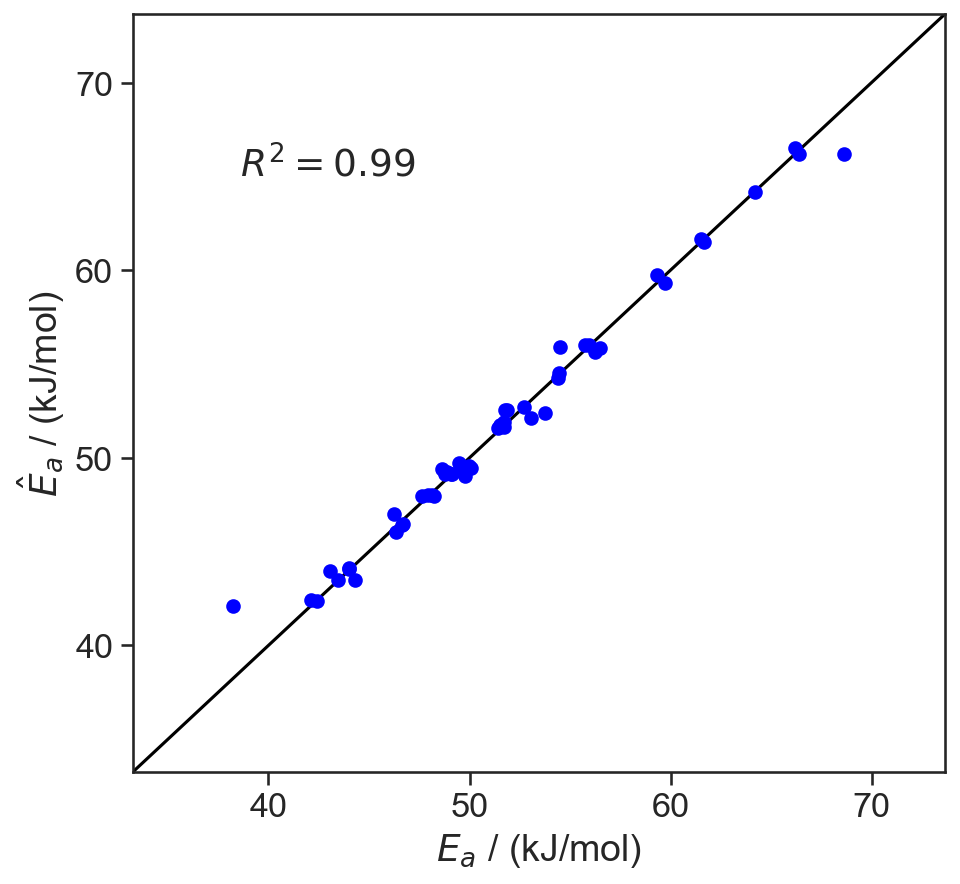

In [3]:
iteration = 30
il_morse = ila.Parser('../logs/IL_50.json')
sampled_sites_iteration = il_morse.sampled_sites(iteration)
model_heights_iteration = il_morse.model_barrier_heights(iteration)
R2 = il_morse.R2(iteration)

model_heights = il_morse.model_barrier_heights(0)

fig, axes = plt.subplots(1, 1, figsize=(6.5,6),dpi=150)


initial_pool = il_morse.sampled_sites(0)
true_barriers = il_morse.true_barrier_heights()
ilp.plot_trained(axes, il_morse.model_training_barrier_heights(0), true_barriers[initial_pool], 50)
axes.set_yticks(axes.get_xticks())
axes.set_ylim(axes.get_xlim())

axes.get_legend().remove()

axes.annotate(r'$R^2 = {:0.2f}$'.format(R2), (0.25, 0.8), xycoords='figure fraction', size=18)
plt.tight_layout()
plt.savefig('f6.png', dpi=600, format='png')


## IL progress

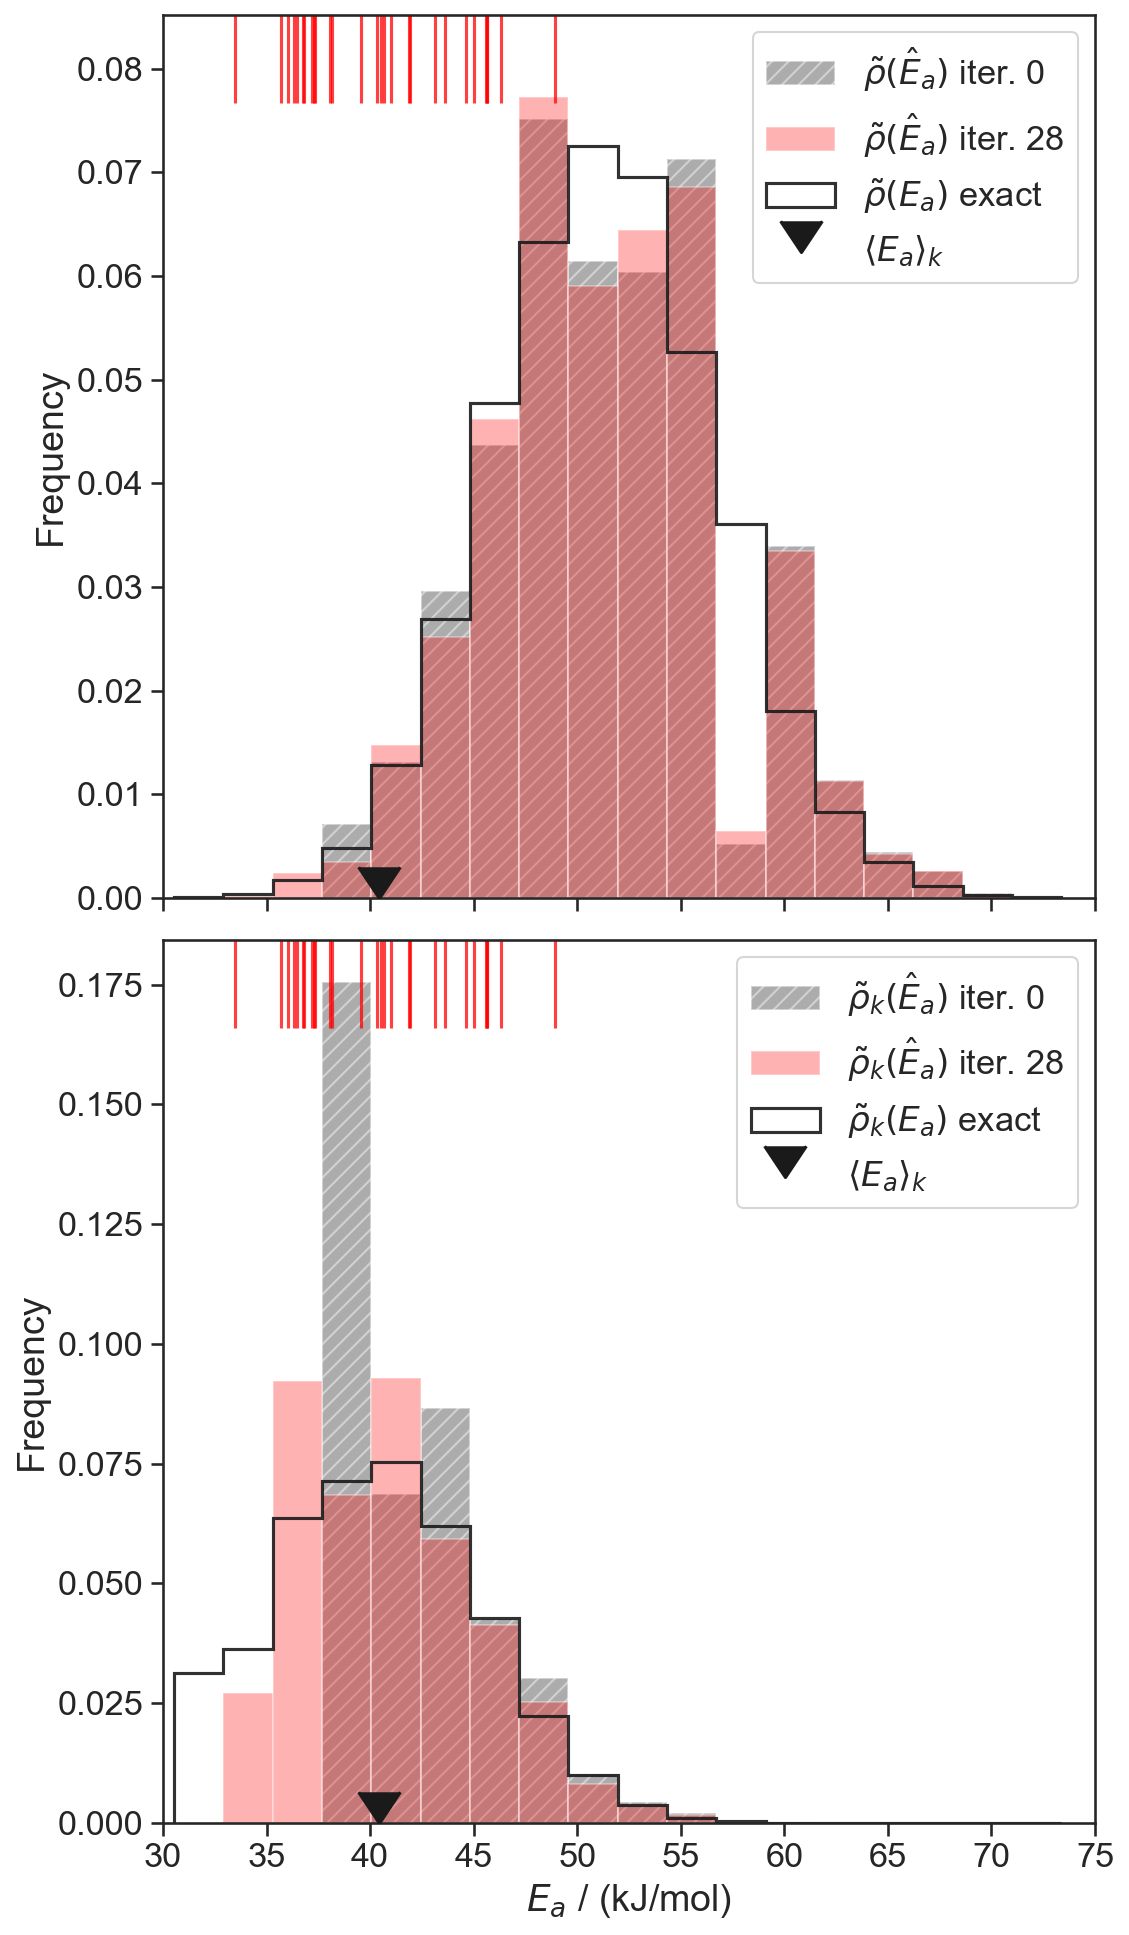

In [4]:
def upper_rugplot(data, height=.1, ax=None, **kwargs):
    from matplotlib.collections import LineCollection
    ax = ax or plt.gca()
    kwargs.setdefault("linewidth", 1.5)
    segs = np.stack((np.c_[data, data],
                     np.c_[np.ones_like(data), np.ones_like(data)-height]),
                    axis=-1)
    lc = LineCollection(segs, transform=ax.get_xaxis_transform(), **kwargs)
    ax.add_collection(lc)

n_bins = 18
iteration = 28
T = 300
il_morse = ila.Parser('../logs/IL_50.json')

initial_pool = il_morse.sampled_sites(0)
model_heights_0 = il_morse.model_barrier_heights(0)
sampled_sites_0 = il_morse.sampled_sites(0)

model_heights_iteration = il_morse.model_barrier_heights(iteration)
sampled_sites_iteration = il_morse.sampled_sites(iteration)

true_barriers = il_morse.true_barrier_heights()

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7.5, 13), dpi=150)

#### Top Plot ####
# Iteration 0
hist = sns.distplot(model_heights_0, ax=axes[0], kde=False, hist=True, bins=n_bins,
             color="#474747", label=r'$\tilde{\rho}(\hat{E}_a)$ iter. 0',
             hist_kws={'range' : (min(true_barriers), max(true_barriers)), 'alpha' : 0.45, 'density' : True})

# Hatches for iter 0
for i in range(n_bins):
    hist.patches[i].set_hatch('///')

# Iteration 30
sns.distplot(model_heights_iteration, ax=axes[0], kde=False, hist=True, bins=n_bins,
             color="red", label=r'$\tilde{\rho}(\hat{E}_a)$ iter. %s' % str(iteration),
             hist_kws={'range' : (min(true_barriers), max(true_barriers)), 'alpha': 0.3, 'density' : True})

plt.setp(axes[0].lines, zorder=10)

# True hist outline
sns.distplot(il_morse.true_barrier_heights(), hist=True, kde=False, ax=axes[0], label=r'$\tilde{\rho}(E_a)$ exact', 
             bins=n_bins, hist_kws={"histtype": "step", "linewidth": 1.5, "alpha": 0.9, "color": "k", 'density' : True})


# Red ticks
upper_rugplot(true_barriers[sampled_sites_iteration[ini_pool_size[1]:]], ax=axes[0], color='red', alpha=0.75)
axes[0].scatter(il_morse.true_site_avg_Ea(),0, marker=7, color='k', s=400, zorder=15, label=r'$\langle E_a \rangle_k$')



#####################
#### Bottom Plot ####
#####################

# Iteration 0
hist = sns.distplot(model_heights_0, ax=axes[1], kde=False, hist=True, bins=n_bins,
             color="#474747", label=r'$\tilde{\rho}_k(\hat{E}_a)$ iter. 0',
             hist_kws={'range' : (min(true_barriers), max(true_barriers)), 'alpha' : 0.45, 'density' : True,
                       'weights': np.exp(-(model_heights_0*1000)/(8.314*T))})

# Hatches for iter 0
for i in range(n_bins):
    hist.patches[i].set_hatch('///')

# Iteration 30
sns.distplot(model_heights_iteration, ax=axes[1], kde=False, hist=True, bins=n_bins,
             color="red", label=r'$\tilde{\rho}_k(\hat{E}_a)$ iter. %s' % str(iteration),
             hist_kws={'range' : (min(true_barriers), max(true_barriers)), 'alpha': 0.3, 'density' : True,
                       'weights': np.exp(-(model_heights_iteration*1000)/(8.314*T))})

plt.setp(axes[1].lines, zorder=100)

# True hist outline
sns.distplot(il_morse.true_barrier_heights(), hist=True, kde=False, ax=axes[1], label=r'$\tilde{\rho}_k(E_a)$ exact', 
             bins=n_bins, hist_kws={"histtype": "step", "linewidth": 1.5, "alpha": 0.9, "color": "k", 'density' : True,
                                    'weights': np.exp(-(il_morse.true_barrier_heights()*1000)/(8.314*T))})

axes[1].scatter(il_morse.true_site_avg_Ea(),0, marker=7, color='k', s=400, zorder=15, label=r'$\langle E_a \rangle_k$')

# Red ticks
upper_rugplot(true_barriers[sampled_sites_iteration[ini_pool_size[1]:]], ax=axes[1], color='red', alpha=0.75)





axes[0].set_ylabel('Frequency')
axes[1].set_ylabel('Frequency')

axes[0].set_xlim([30, 75])

# axes[0].set_xlabel(r'$E_a$, kJ/mol')
axes[1].set_xlabel(r'$E_a$ / (kJ/mol)')

axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.savefig('f7.png', dpi=600, format='png')

plt.show()

In [5]:
il_morse = ila.Parser('../logs/IL_50.json')
with np.printoptions(precision=0, suppress=True):
    print(il_morse.model_coefficients(30))

[[ 77068. -56512.    -45.]
 [-56512.  41440.     32.]
 [   -45.     32.      0.]]


## $\langle E_a \rangle_k$ convergence

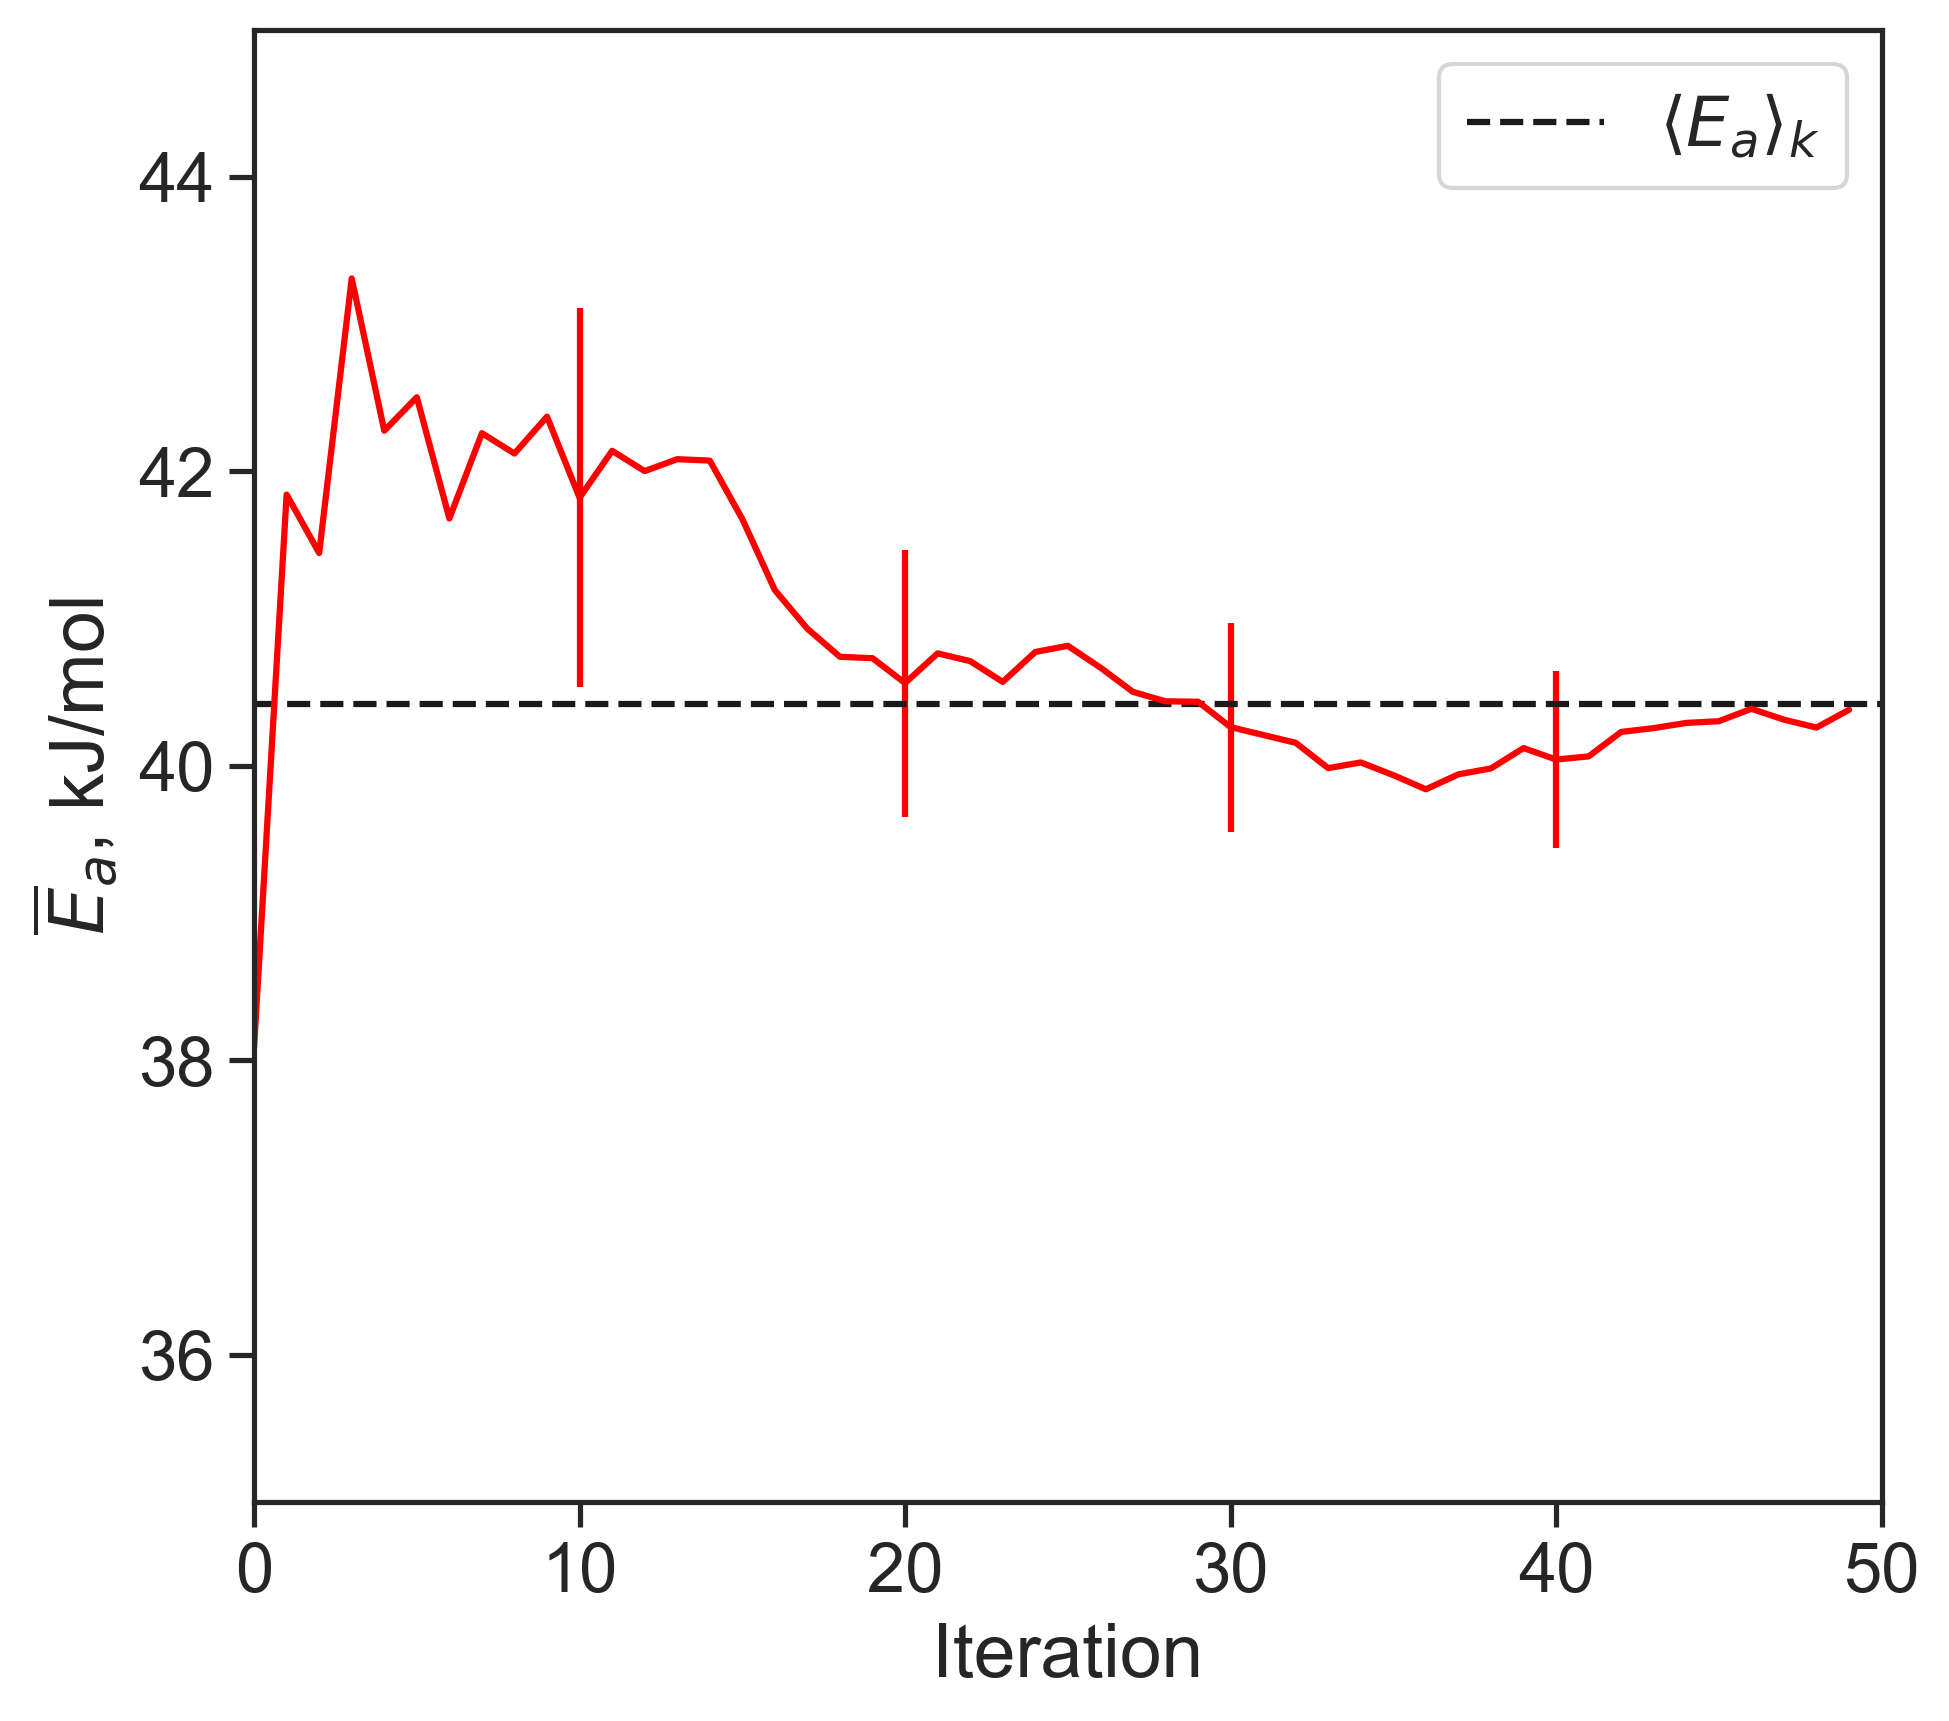

In [6]:
from il import biased_error

il_morse = ila.Parser('../logs/IL_{}.json'.format(50))

avg_Ea_exact = il_morse.true_site_avg_Ea()
avg_Ea_pred = il_morse.all_site_avg_Ea()
sampled_Ea = il_morse.sampled_barrier_heights(0)

# print(sampled_Ea)

avg_Ea_pred_err = [biased_error(il_morse.sampled_barrier_heights(i)[50:]) for i in range(50)]
# print(avg_Ea_pred_err)
# print(il_morse.all_site_Ea_sampling_error())
avg_Ea_pred_err = il_morse.all_site_Ea_sampling_error()[0:50]
n_iterations =il_morse.n_iterations

fig, axs = plt.subplots(1, 1, figsize=(7, 6.5), dpi=300)


ilp.plot_convergence(axs, 50, avg_Ea_pred[0:50], avg_Ea_pred_err, avg_Ea_exact, 10)
axs.set_ylim(bottom=35, top=45)
avg_Ea_pred_err[20]
plt.savefig('f8.png', dpi=600, format='png')

# [print(i, avg_Ea_pred_err[i]) for i in range(40)]

## Fits removing unimportant local coordinates

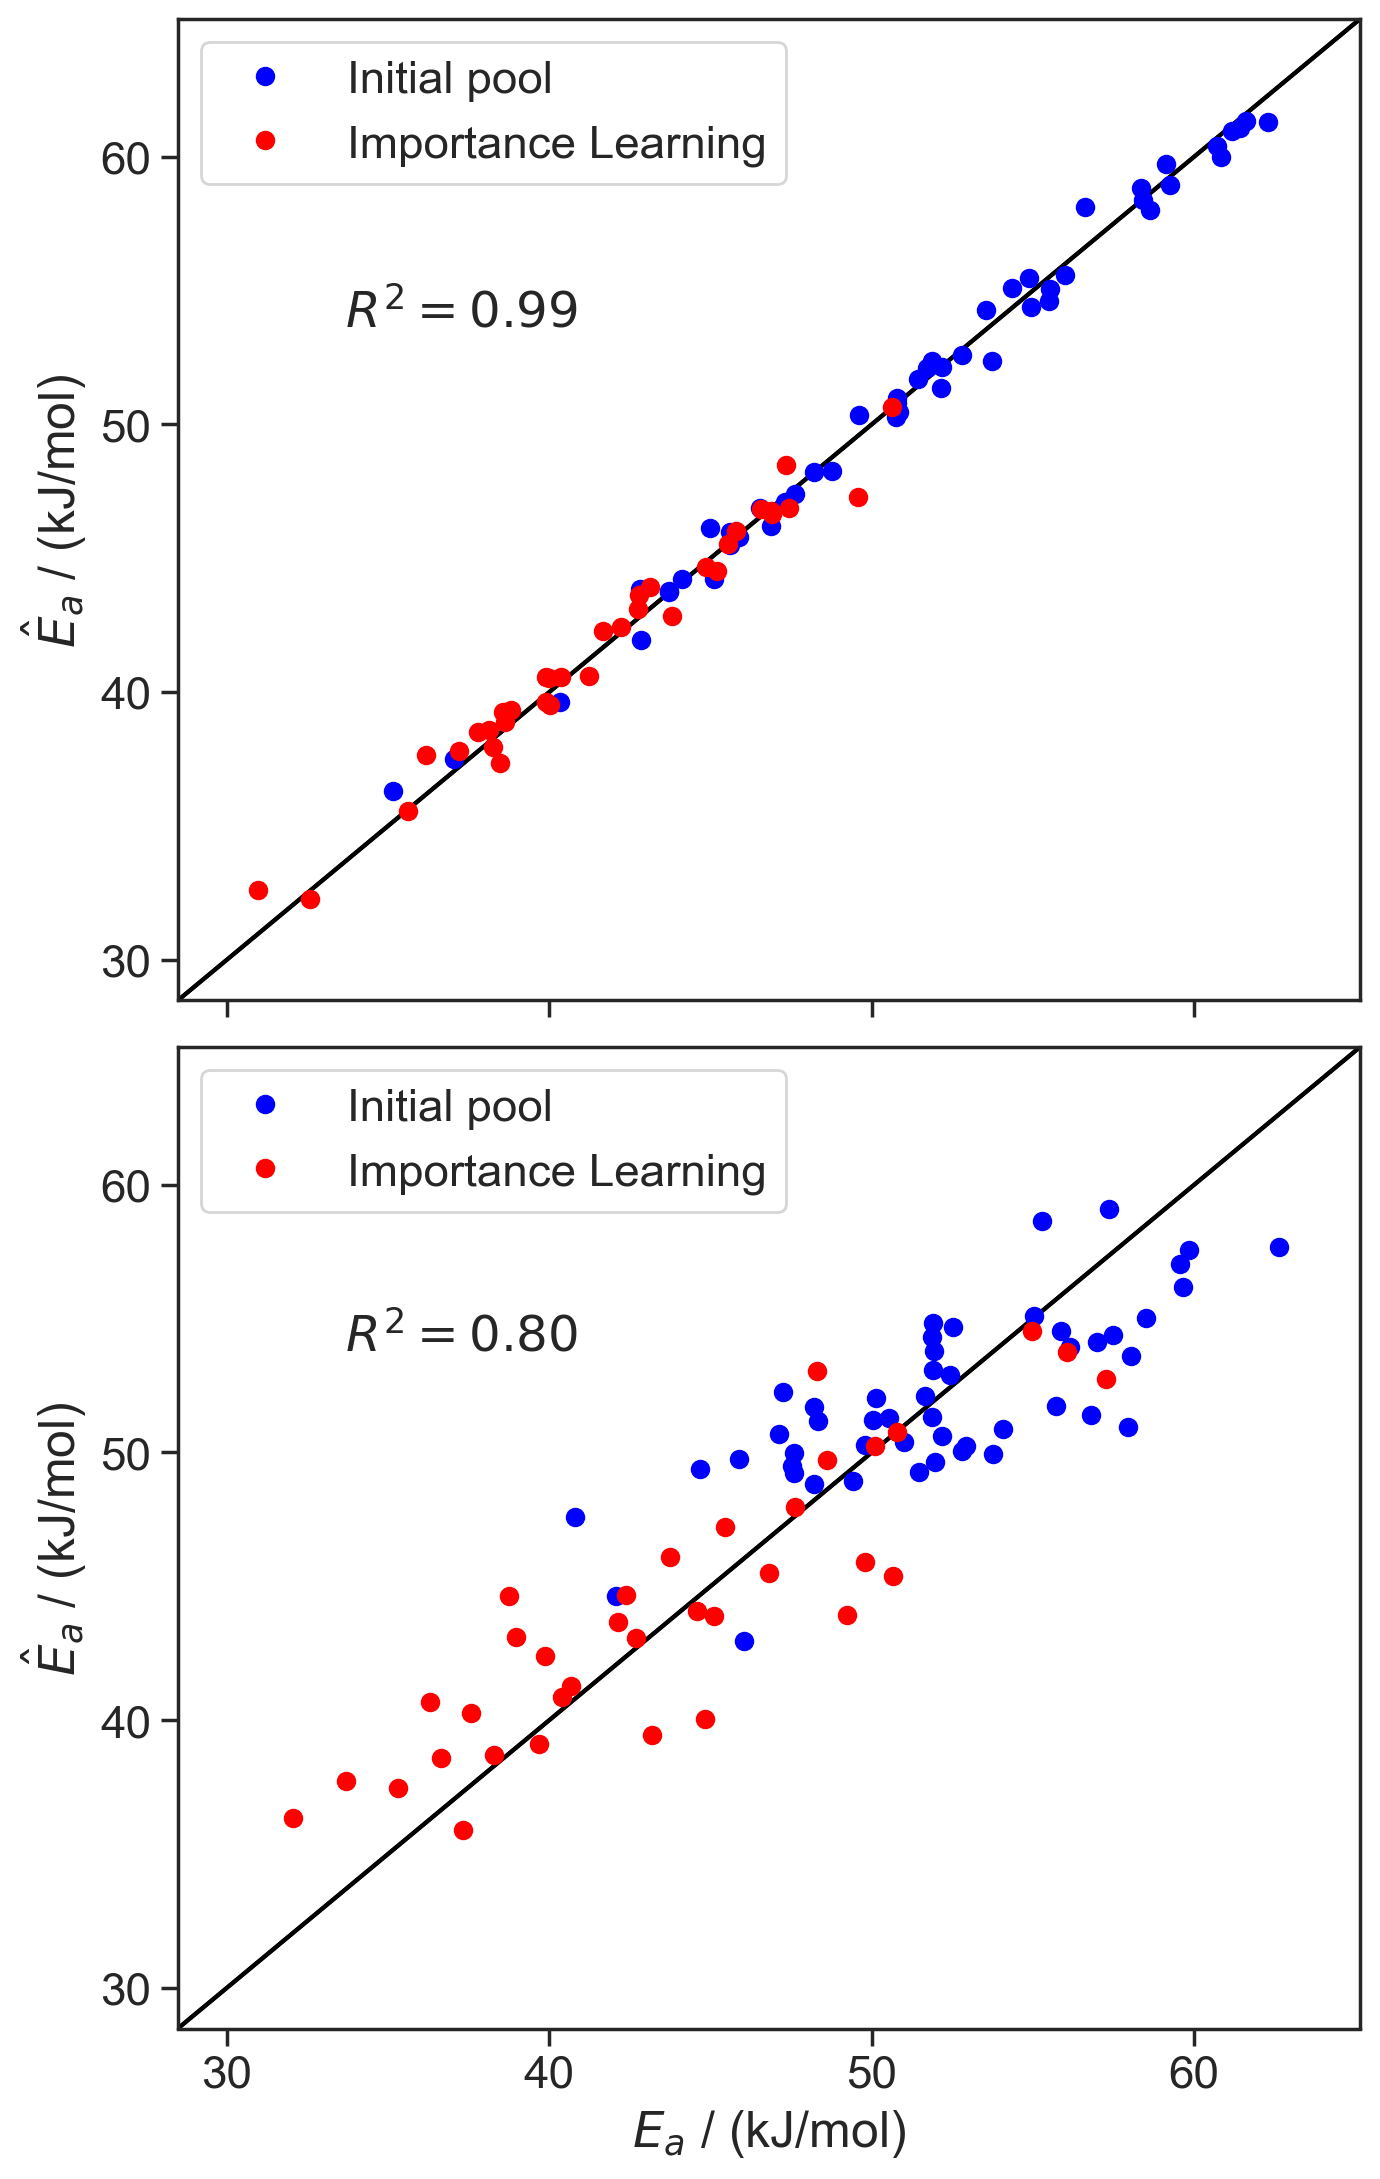

(0.9918494797479225, 0.8042704942001553)

In [7]:
d1d2_morse = ila.Parser('../logs/IL_50_d1_d2.json')
d1_morse = ila.Parser('../logs/IL_50_d1.json')

iteration = 35

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(7, 11), dpi=200)

model_heights_d1d2 = d1d2_morse.model_training_barrier_heights(iteration)
initial_pool_d1d2 = d1d2_morse.sampled_sites(iteration)
true_barriers_d1d2 = d1d2_morse.true_barrier_heights()
R2_d1d2 = d1d2_morse.R2(iteration)

model_heights_d1 = d1_morse.model_training_barrier_heights(iteration)
initial_pool_d1 = d1_morse.sampled_sites(iteration)
true_barriers_d1 = d1_morse.true_barrier_heights()
R2_d1 = d1_morse.R2(iteration)

ip_size = 50



ilp.plot_trained(axes[0], model_heights_d1d2, true_barriers_d1d2[initial_pool_d1d2], 50)
ilp.plot_trained(axes[1], model_heights_d1, true_barriers_d1[initial_pool_d1], 50)

min_barrier = np.min((true_barriers_d1d2[initial_pool_d1d2], true_barriers_d1[initial_pool_d1])) - 2.5
max_barrier = np.max((true_barriers_d1d2[initial_pool_d1d2], true_barriers_d1[initial_pool_d1])) + 2.5

x_line = [min_barrier, max_barrier]
y_line = [min_barrier, max_barrier]

axes[0].plot(x_line, y_line, color="Black", zorder=0)
axes[1].plot(x_line, y_line, color="Black", zorder=0)

axes[0].set_ylim(y_line)
axes[0].set_xlim(x_line)

axes[1].set_ylim(y_line)
axes[1].set_xlim(x_line)

axes[0].set_xlabel('')

axes[0].annotate(r'$R^2 = {:0.2f}$'.format(R2_d1d2), (0.25, 0.85), xycoords='figure fraction', size=18)
axes[1].annotate(r'$R^2 = {:0.2f}$'.format(R2_d1), (0.25, 0.38), xycoords='figure fraction', size=18)

axes[0].set_yticks([30, 40, 50, 60])
axes[1].set_yticks([30, 40, 50, 60])
axes[1].set_xticks([30, 40, 50, 60])

fig.tight_layout()
plt.savefig('f9.png', dpi=600, format='png')

plt.show()
R2_d1d2, R2_d1

In [8]:
files = ['IL_50_d1.json', 'IL_50_d2.json', 'IL_50_theta.json',
         'IL_50_d1_d2.json', 'IL_50_d1_theta.json', 'IL_50_d2_theta.json',
         'IL_50.json']

for f in files:
    print('{:0.3f}'.format(ila.Parser('../logs/'+f).R2(28)))


0.797
0.157
-0.026
0.992
0.817
0.335
0.993


##  Activity map

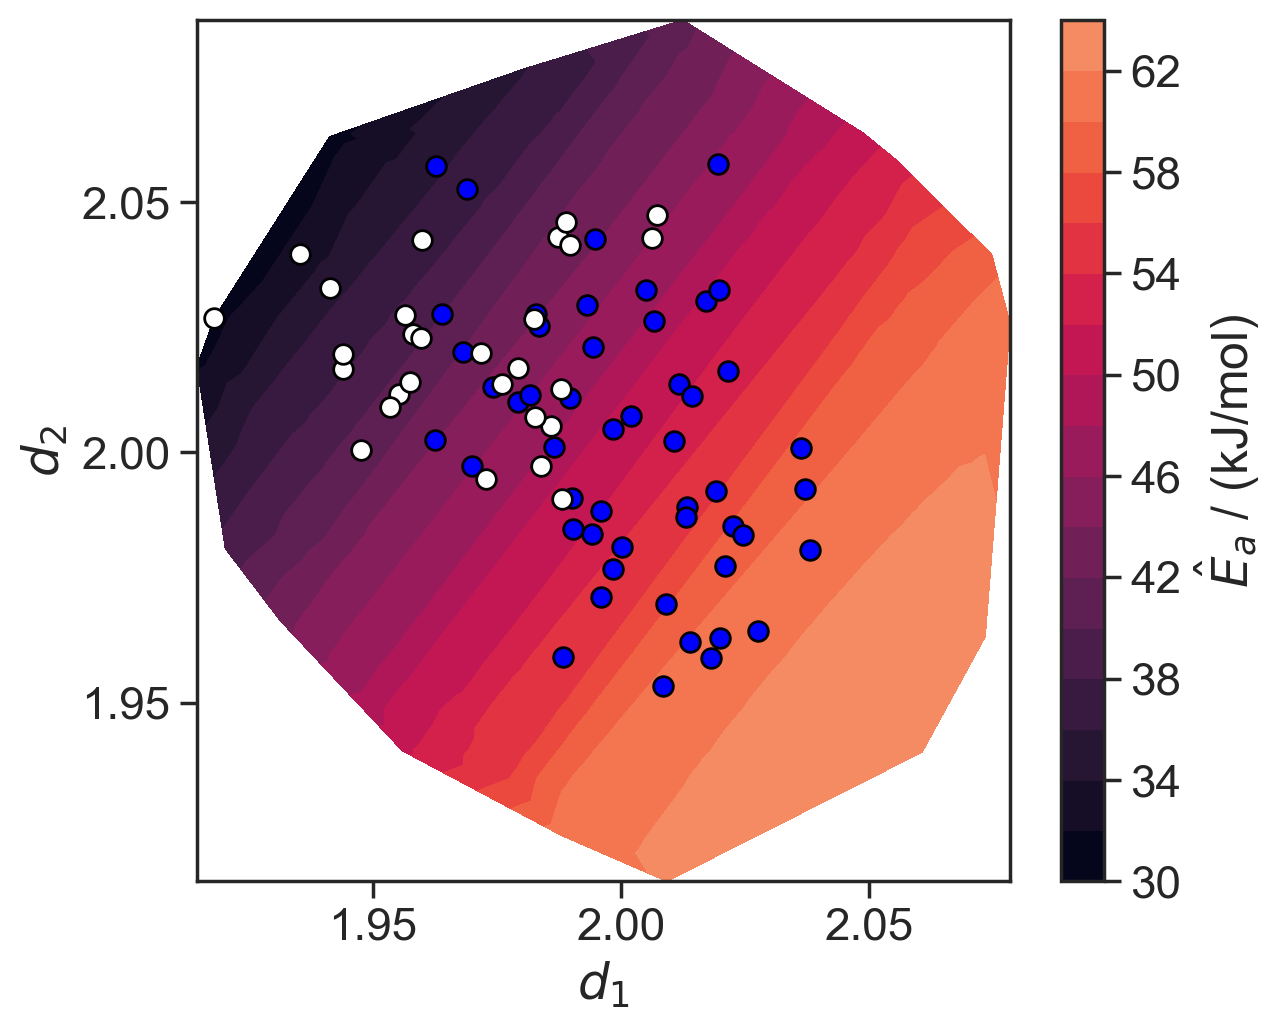

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 5.25), dpi=200)

iteration = 28

il_morse = ila.Parser('../logs/IL_50_d1_d2.json')
local_coordinates = il_morse.local_coordinates()
true_barriers = il_morse.true_barrier_heights()
model_heights = il_morse.model_barrier_heights(iteration)

sampled_local_coordinates = il_morse.sampled_local_coordinates(iteration)
initial_pool = il_morse.sampled_local_coordinates(0)
initial_pool_barriers = il_morse.sampled_barrier_heights(0)


min_barrier = np.min((true_barriers, model_heights))
max_barrier = np.max((true_barriers, model_heights))

tri2 = axs.tricontourf(local_coordinates[:,0], local_coordinates[:, 1], model_heights, 15, 
                   vmin=min_barrier, vmax=max_barrier)
axs.scatter(initial_pool[:,0], initial_pool[:,1], s=50, c='blue', edgecolors='black', label='Initial Pool')
axs.scatter(sampled_local_coordinates[50:,0], sampled_local_coordinates[50:,1], s=50, c='w', edgecolors='black', label='Importance Sampled')

cbar0 = fig.colorbar(tri2, ax=axs)

# axs.set_title('Model Predicted Barriers, Iteration {}'.format(iteration))
cbar0.set_label(r'$\hat{E}_{a}$ / (kJ/mol)')
axs.set_ylabel(r'$d_2$')
axs.set_xlabel(r'$d_1$')

axs.set_yticks([1.95, 2.00, 2.05])

plt.tight_layout()
plt.savefig('f10.png', dpi=600, format='png')

plt.show()



##  reduced model IL convergence

array([0.        , 4.86453578, 2.37253652, 2.51446342, 2.18936536,
       1.78966696, 1.71997895, 1.59597784, 1.41208585, 1.28638038,
       1.28709986, 1.21695034, 1.12741257, 1.04654953, 0.97405526,
       0.99381702, 1.05066157, 1.02459522, 0.987533  , 0.93679963,
       0.90682857, 0.88771023, 0.84980743, 0.82571232, 0.8175596 ,
       0.78656477, 0.77111119, 0.76105744, 0.7371314 , 0.71211934,
       0.7099806 , 0.68948229, 0.67036825, 0.67270801, 0.65435467,
       0.64173681, 0.63147039, 0.62291527, 0.60805546, 0.60851985,
       0.59856502, 0.58451972, 0.59444058, 0.58133681, 0.56936548,
       0.55696509, 0.55145013, 0.5448108 , 0.53628671, 0.5391183 ,
       0.53339693, 0.54320079, 0.53330373, 0.52732442, 0.51869953,
       0.51952752, 0.5103425 , 0.50155998, 0.50484196, 0.49808338,
       0.48985792, 0.48189118, 0.47817536, 0.47065313, 0.46335808,
       0.45631195, 0.47362971, 0.46720135, 0.46479619, 0.45813367,
       0.45416667, 0.45159539, 0.44578475, 0.44207385, 0.44196

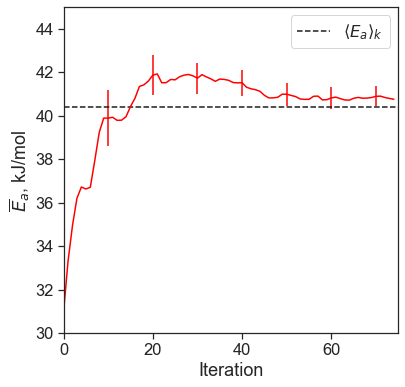

In [10]:
il_morse = ila.Parser('../logs/IL_50_d1_d2.json')

avg_Ea_exact = il_morse.true_site_avg_Ea()
avg_Ea_pred = il_morse.all_site_avg_Ea()
avg_Ea_pred_err = il_morse.all_site_Ea_sampling_error()
n_iterations =il_morse.n_iterations

fig, axs = plt.subplots(1, 1, figsize=(6, 6))


ilp.plot_convergence(axs, n_iterations, avg_Ea_pred, avg_Ea_pred_err, avg_Ea_exact, 10)
axs.set_ylim(bottom=30, top=45)
avg_Ea_pred_err

## Error distribution at iteration 0 and 30

-7.7220972111242645 4.721495490091087
Iteartion 0 standard deviation: 0.7 kJ/mol
Iteartion 30 standard deviation: 0.6 kJ/mol


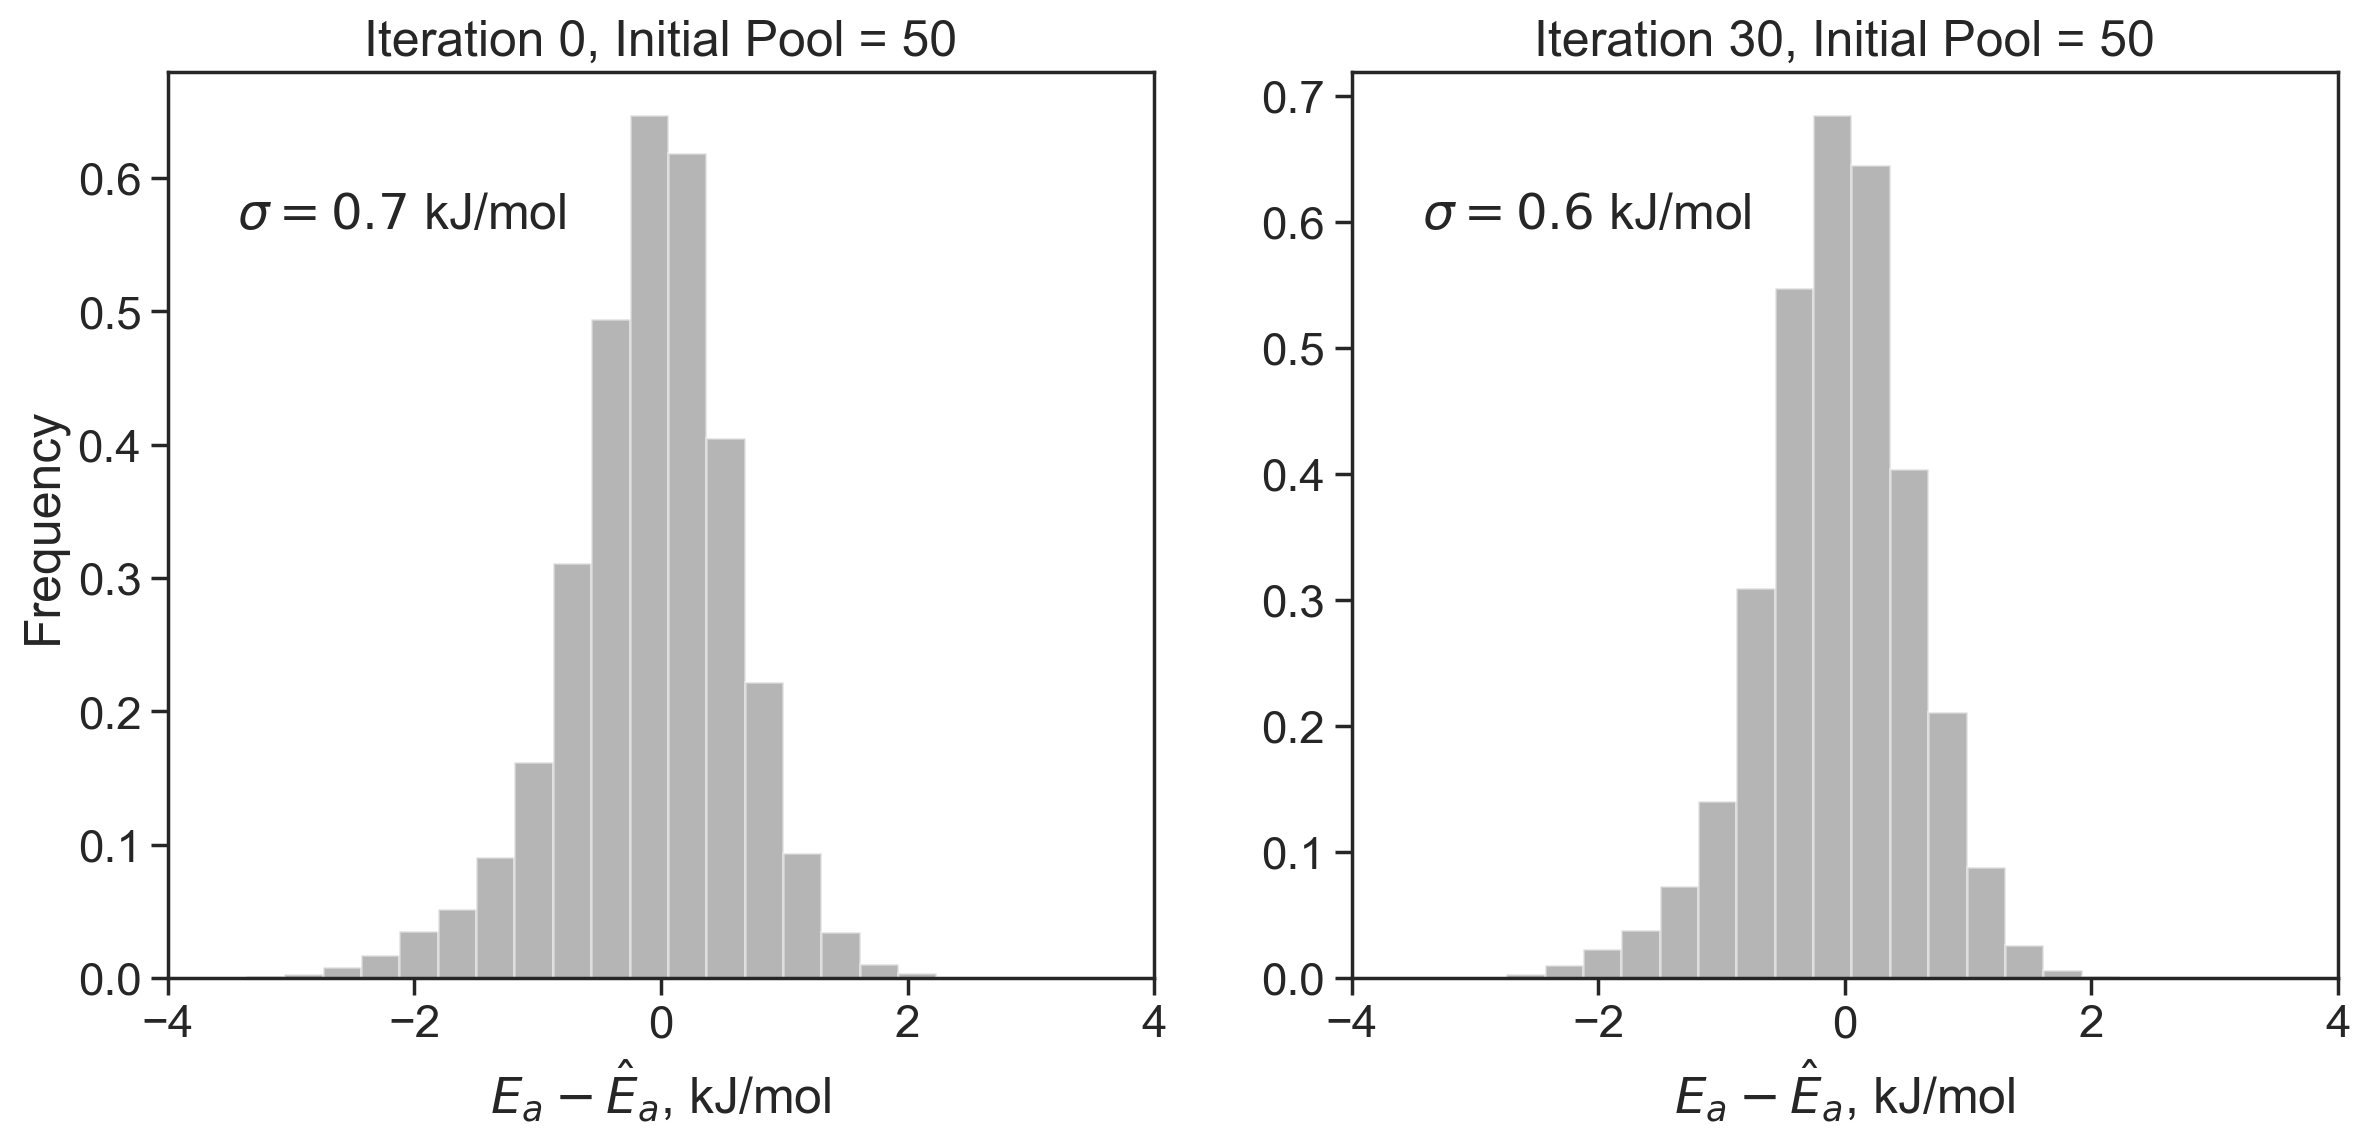

In [11]:
iteration = 30
il_morse = ila.Parser('../logs/IL_50.json')

model_heights_0 = il_morse.model_barrier_heights(0)
model_heights_iteration = il_morse.model_barrier_heights(iteration)

min_bar = np.min((il_morse.true_barrier_heights() - model_heights_0, il_morse.true_barrier_heights() - model_heights_iteration))
max_bar = np.max((il_morse.true_barrier_heights() - model_heights_0, il_morse.true_barrier_heights() - model_heights_iteration))

print(min_bar, max_bar)

R2_0 = il_morse.R2(0)
R2_iteration = il_morse.R2(iteration)



fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=200)
sns.distplot(il_morse.true_barrier_heights() - model_heights_0, ax=axes[0], kde=False, color='#474747', 
             bins=40, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})
print("Iteartion 0 standard deviation: {:.1f} kJ/mol".format(np.std(model_heights_0 - il_morse.true_barrier_heights())))

sns.distplot(il_morse.true_barrier_heights() - model_heights_iteration, ax=axes[1], kde=False, color='#474747', 
             bins=40, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})

# hist_kws={'range' : (min(true_barriers), max(true_barriers)), 'alpha' : 0.45, 'density' : True})

print("Iteartion {} standard deviation: {:.1f} kJ/mol".format(iteration, np.std(model_heights_iteration - il_morse.true_barrier_heights())))

axes[0].set_xlabel(r'$E_{a} - \hat{E}_{a}$, kJ/mol')
axes[1].set_xlabel(r'$E_{a} - \hat{E}_{a}$, kJ/mol')
axes[0].set_ylabel('Frequency')

# axes[0].set_xlim([-3, 3])
# axes[1].set_xlim([-3, 3])

axes[0].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(model_heights_0 - il_morse.true_barrier_heights())), 
                 (0.1, 0.8), xycoords='figure fraction', size=18)

axes[1].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(model_heights_iteration - il_morse.true_barrier_heights())), 
                 (0.6, 0.8), xycoords='figure fraction', size=18)


axes[0].set_title('Iteration 0, Initial Pool = 50')
axes[1].set_title('Iteration {}, Initial Pool = 50'.format(iteration))

axes[0].set_xlim([-4,4])
axes[1].set_xlim([-4,4])


plt.show()

## ML errors with training set size

<Figure size 864x864 with 0 Axes>

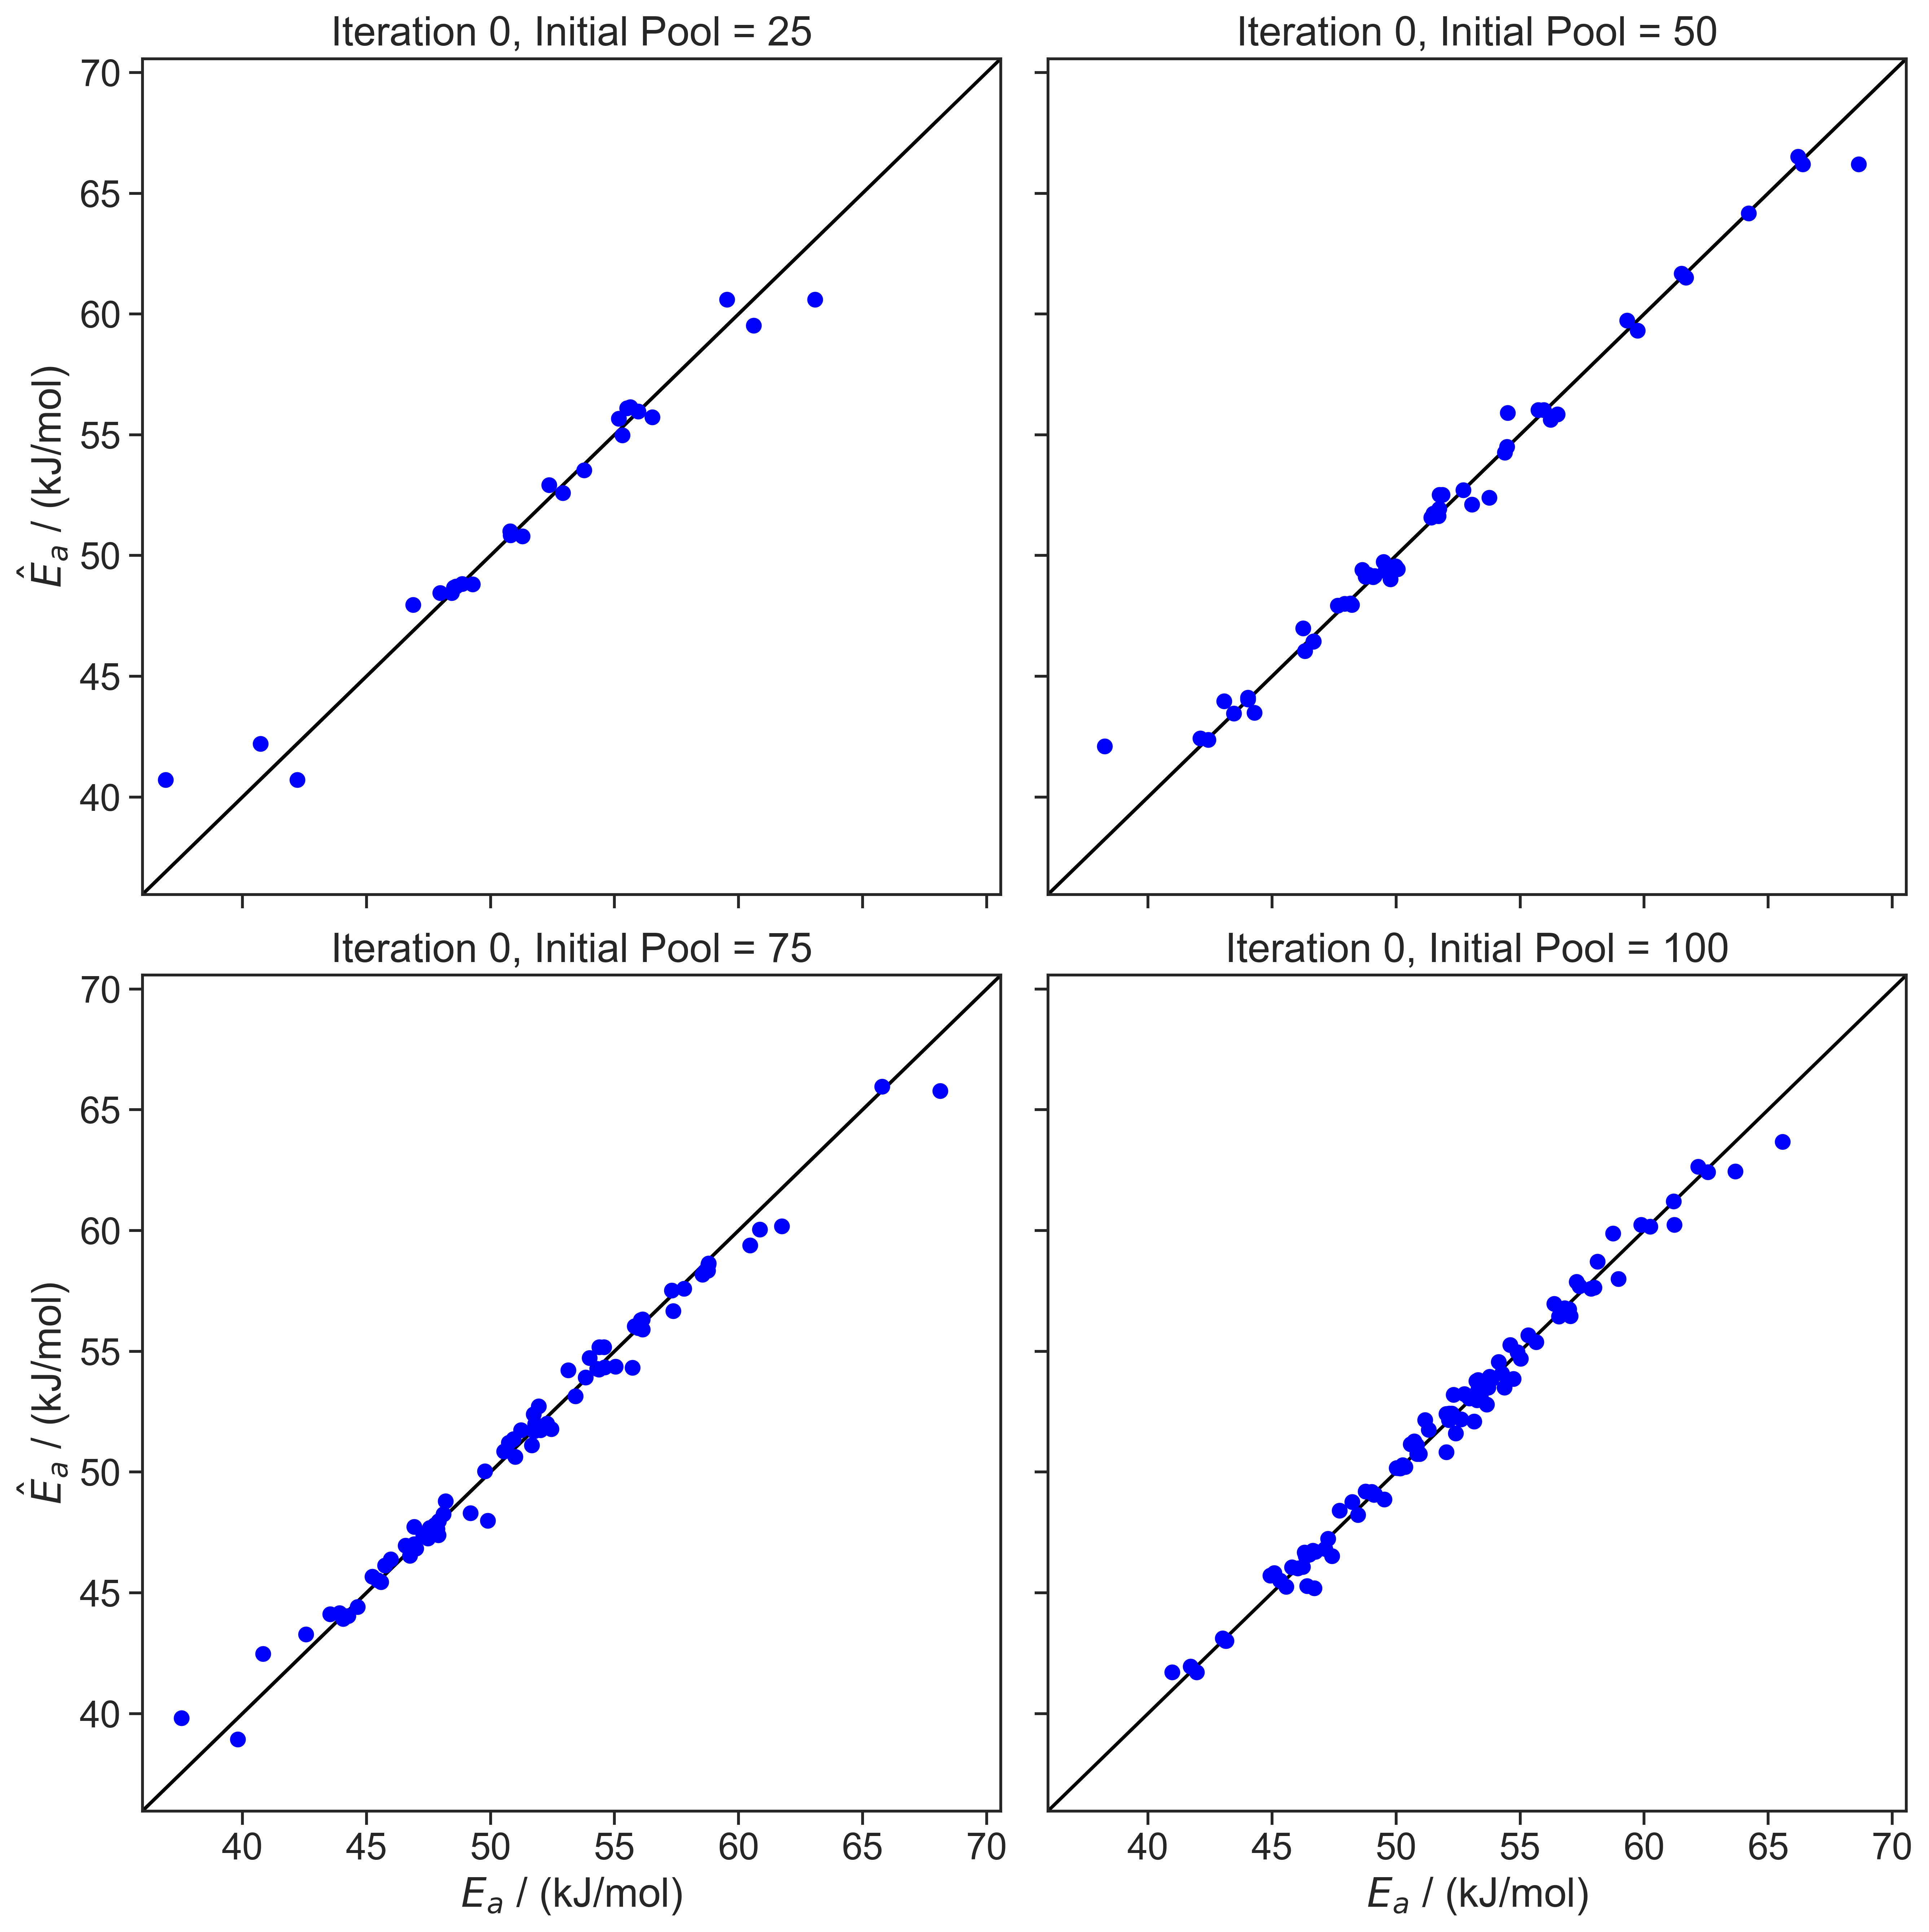

In [12]:
fig = plt.figure(figsize=(12,12))
ini_pool_size = [25, 50, 75, 100]
fig, axes = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True, dpi=450)
for i in range(4):
    il_gaussian = ila.Parser('../logs/IL_{}.json'.format(ini_pool_size[i]))
    model_heights = il_gaussian.model_training_barrier_heights(0)
    initial_pool = il_gaussian.sampled_sites(0)
    true_barriers = il_gaussian.true_barrier_heights()
    if i == 0:
        ilp.plot_trained(axes[0,0], model_heights, true_barriers[initial_pool], ini_pool_size[i])
        axes[0,0].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))
        axes[0,0].set_xlabel('')
    elif i == 1:
        ilp.plot_trained(axes[0,1], model_heights, true_barriers[initial_pool], ini_pool_size[i])
        axes[0,1].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))
        axes[0,1].set_xlabel('')
        axes[0,1].set_ylabel('')
        
    elif i == 2:
        ilp.plot_trained(axes[1,0], model_heights, true_barriers[initial_pool], ini_pool_size[i])
        axes[1,0].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))    
        
    else:
        ilp.plot_trained(axes[1,1], model_heights, true_barriers[initial_pool], ini_pool_size[i])
        axes[1,1].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))    
        axes[1,1].set_ylabel('')
        
min_barrier = np.min(true_barriers[initial_pool]) - 2.5
max_barrier = np.max(true_barriers[initial_pool]) + 2.5

x_line = np.asarray(axes[1,1].get_xlim())
y_line = np.asarray(axes[1,1].get_ylim())

axes[0,0].plot(x_line, y_line, color="Black", zorder=0)
axes[0,1].plot(x_line, y_line, color="Black", zorder=0)
axes[1,0].plot(x_line, y_line, color="Black", zorder=0)

axes[0,0].get_legend().remove()
axes[1,0].get_legend().remove()
axes[0,1].get_legend().remove()
axes[1,1].get_legend().remove()


plt.tight_layout()
plt.show()


<Figure size 864x864 with 0 Axes>

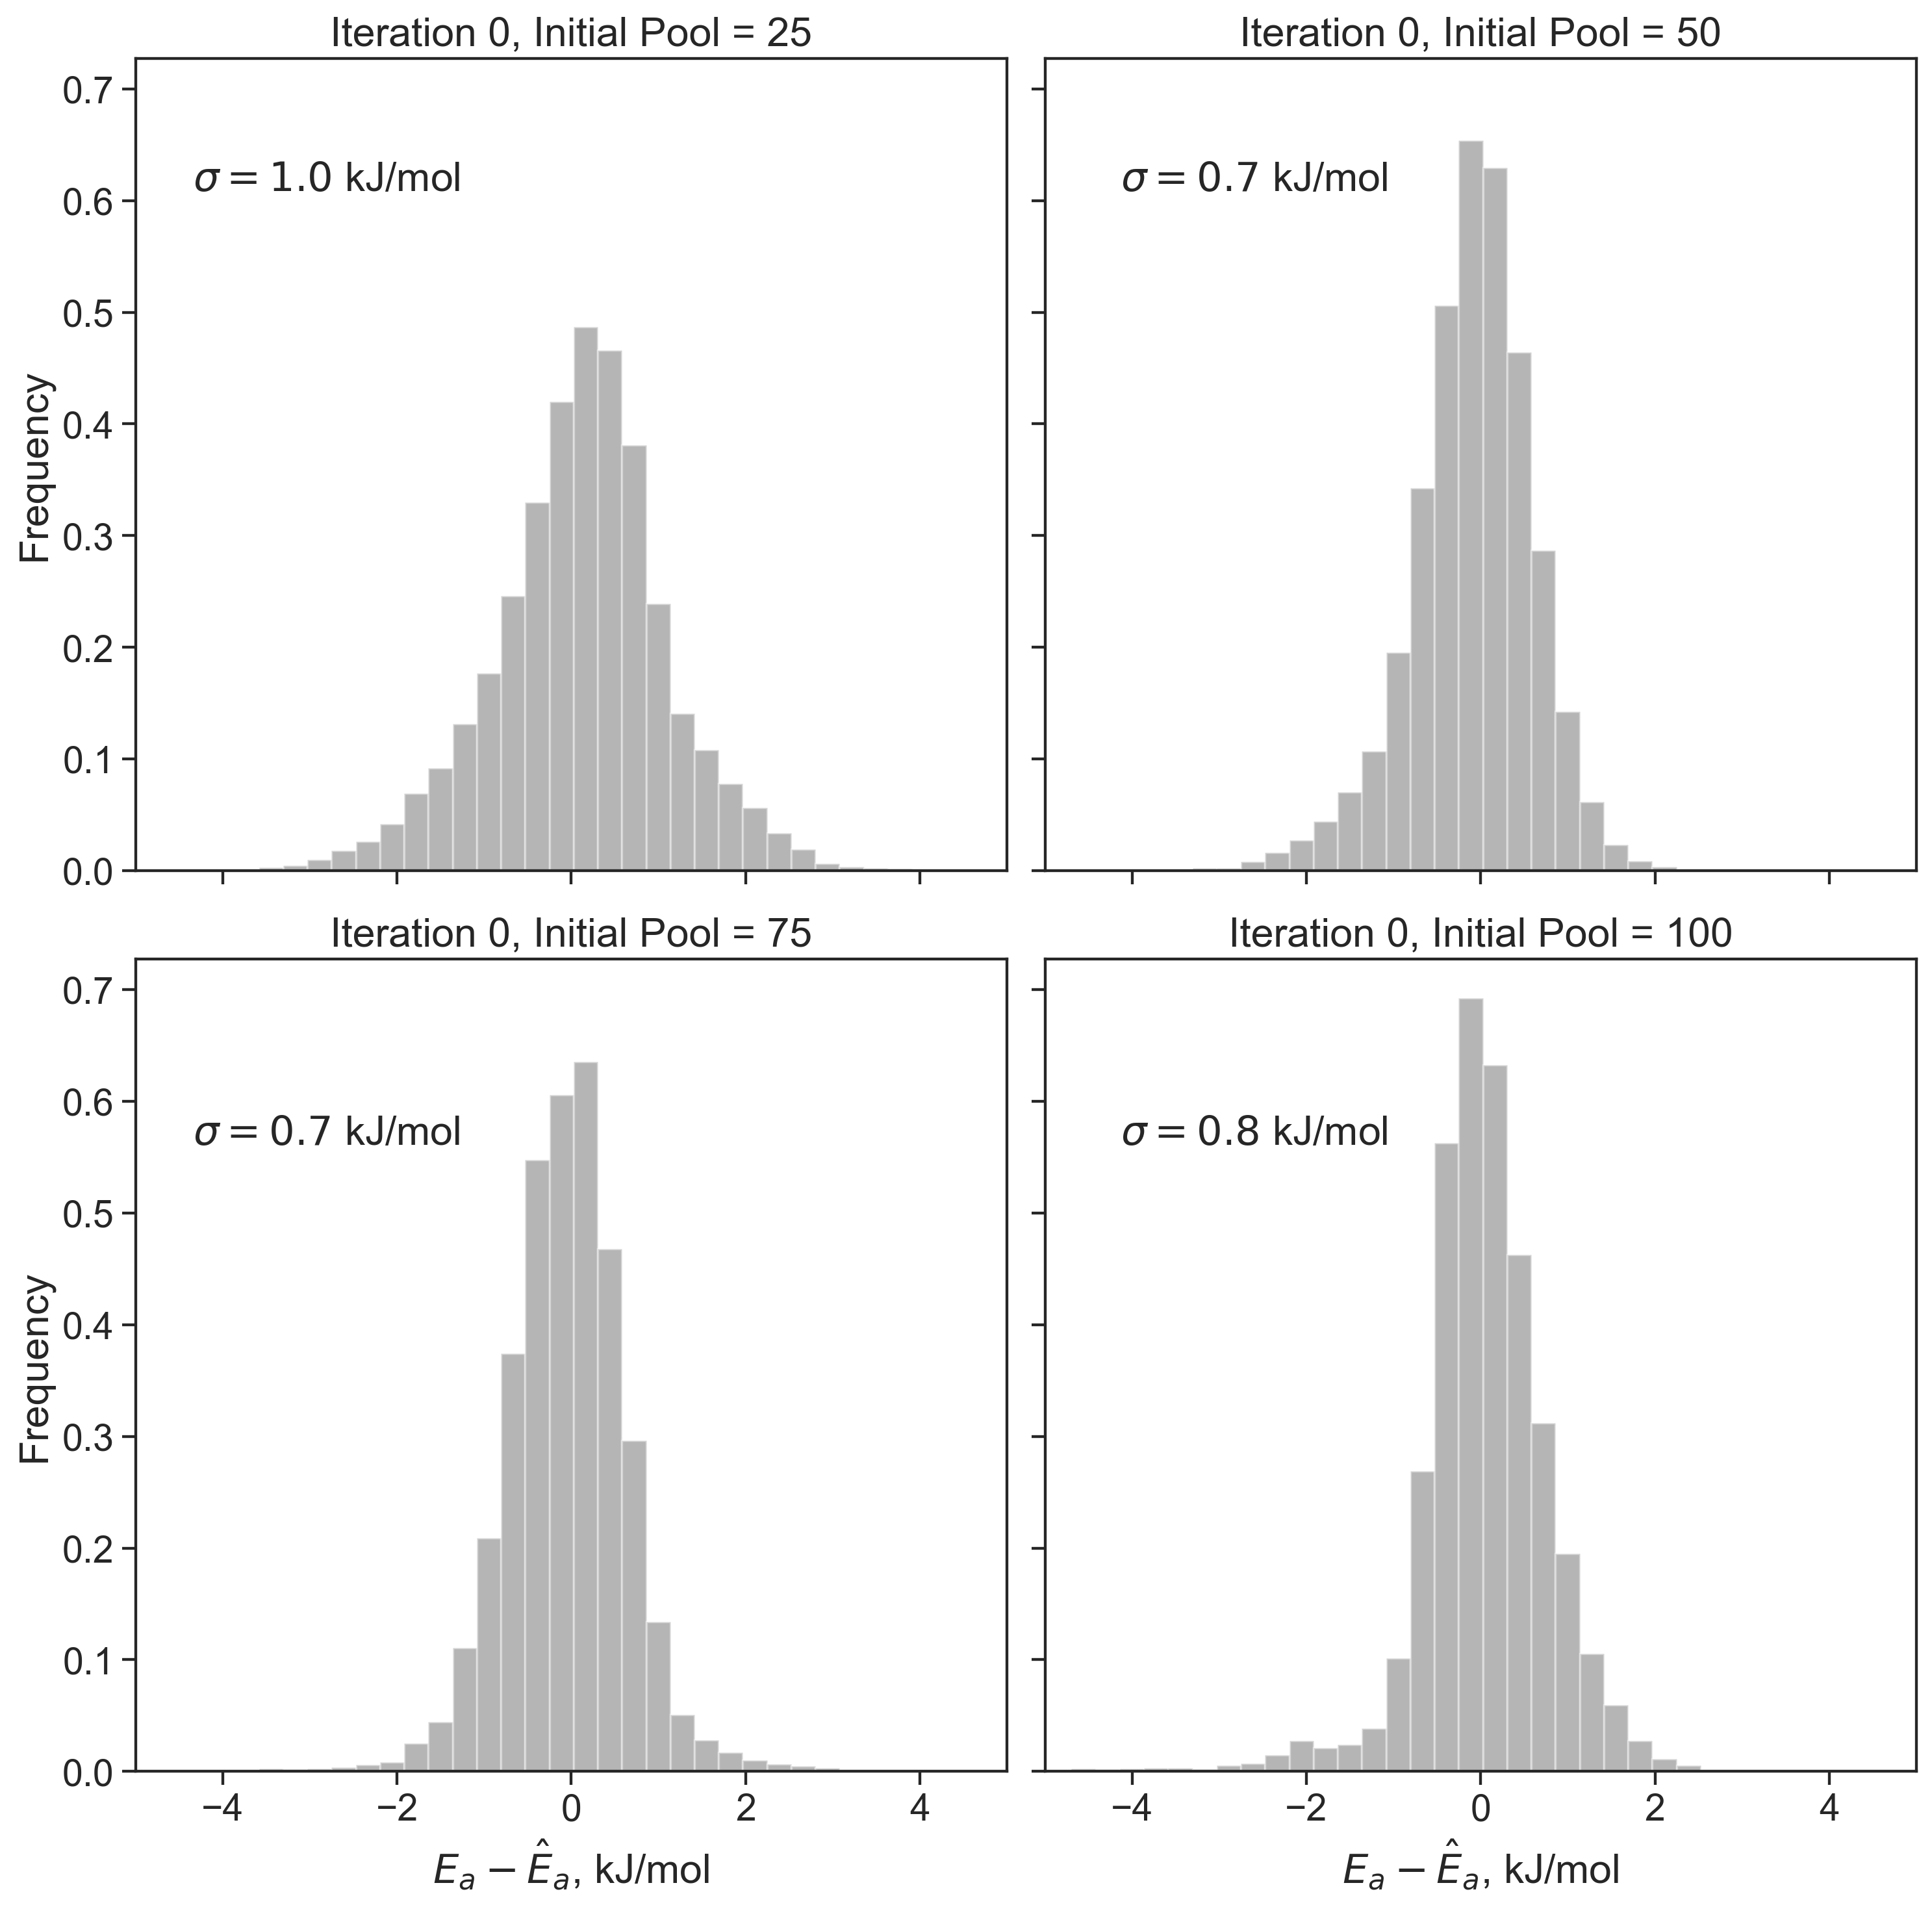

In [13]:
fig = plt.figure(figsize=(12,12))
ini_pool_size = [25, 50, 75, 100]
fig, axes = plt.subplots(2, 2, figsize=(12,12), sharex=True, sharey=True, dpi=250)
for i in range(4):
    il_gaussian = ila.Parser('../logs/IL_{}.json'.format(ini_pool_size[i]))
    model_heights = il_gaussian.model_training_barrier_heights(0)
    initial_pool = il_gaussian.sampled_sites(0)
    true_barriers = il_gaussian.true_barrier_heights()
    if i == 0:
        min_bar = np.min(true_barriers - il_gaussian.model_barrier_heights(0))
        max_bar = np.max(true_barriers - il_gaussian.model_barrier_heights(0))
        
        sns.distplot(true_barriers - il_gaussian.model_barrier_heights(0), ax=axes[0,0], kde=False, color='#474747', 
             bins=60, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})
        axes[0,0].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))
        axes[0,0].set_xlabel('')
        axes[0,0].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(true_barriers - il_gaussian.model_barrier_heights(0))), 
                 (0.1, 0.9), xycoords='figure fraction', size=18)
        axes[0,0].set_ylabel('Frequency')
        
        
    elif i == 1:
        sns.distplot(true_barriers - il_gaussian.model_barrier_heights(0), ax=axes[0,1], kde=False, color='#474747', 
             bins=60, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})
        axes[0,1].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))
        axes[0,1].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(true_barriers - il_gaussian.model_barrier_heights(0))), 
                 (0.58, 0.9), xycoords='figure fraction', size=18)        
        
    elif i == 2:
        sns.distplot(true_barriers - il_gaussian.model_barrier_heights(0), ax=axes[1,0], kde=False, color='#474747', 
             bins=60, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})
        axes[1,0].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))    
        axes[1,0].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(true_barriers - il_gaussian.model_barrier_heights(0))), 
                 (0.1, 0.4), xycoords='figure fraction', size=18)
        axes[1,0].set_xlabel(r'$E_{a} - \hat{E}_{a}$, kJ/mol')
        axes[1,0].set_ylabel('Frequency')
        
    else:
        sns.distplot(true_barriers - il_gaussian.model_barrier_heights(0), ax=axes[1,1], kde=False, color='#474747', 
             bins=60, hist_kws={'density' : True, 'range' : (min_bar, max_bar)})
        axes[1,1].set_title('Iteration 0, Initial Pool = {}'.format(ini_pool_size[i]))    
        axes[1,1].set_ylabel('')
        axes[1,1].annotate(r'$\sigma = {:.1f}$ kJ/mol'.format(np.std(true_barriers - il_gaussian.model_barrier_heights(0))), 
                 (0.58, 0.4), xycoords='figure fraction', size=18)
        axes[1,1].set_xlabel(r'$E_{a} - \hat{E}_{a}$, kJ/mol')

        
min_barrier = np.min(true_barriers[initial_pool]) - 2.5
max_barrier = np.max(true_barriers[initial_pool]) + 2.5

x_line = np.asarray(axes[1,1].get_xlim())
y_line = np.asarray(axes[1,1].get_ylim())

axes[0,0].set_xlim([-5,5])

# axes[0,0].plot(x_line, y_line, color="Black", zorder=0)
# axes[0,1].plot(x_line, y_line, color="Black", zorder=0)
# axes[1,0].plot(x_line, y_line, color="Black", zorder=0)
    
    
plt.tight_layout()
plt.show()

## True barrier activity map

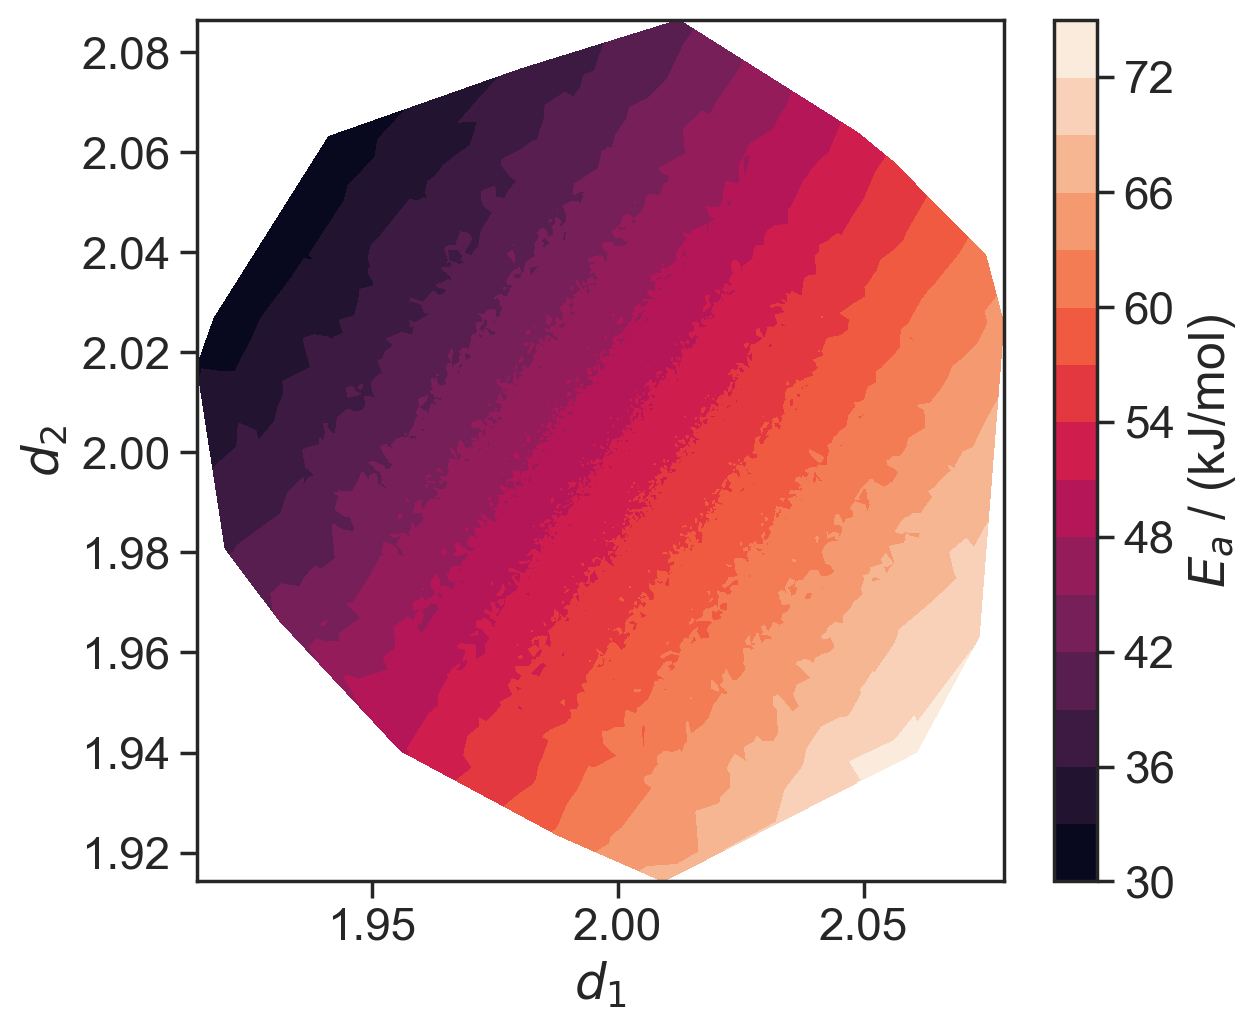

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(6.5, 5.25), dpi=200)

iteration = 30

il_morse = ila.Parser('../logs/IL_{}_d1_d2.json'.format(50))
local_coordinates = il_morse.local_coordinates()
true_barriers = il_morse.true_barrier_heights()
model_heights = il_morse.model_barrier_heights(iteration)

sampled_local_coordinates = il_morse.sampled_local_coordinates(iteration)
initial_pool = il_morse.sampled_local_coordinates(0)
initial_pool_barriers = il_morse.sampled_barrier_heights(0)


min_barrier = np.min((true_barriers, model_heights))
max_barrier = np.max((true_barriers, model_heights))

tri1 = axs.tricontourf(local_coordinates[:,0], local_coordinates[:, 1], true_barriers, 15, 
                   vmin=min_barrier, vmax=max_barrier)

cbar0 = fig.colorbar(tri1, ax=axs)
cbar0.set_label(r'$E_a$ / (kJ/mol)')
axs.set_ylabel(r'$d_2$')
axs.set_xlabel(r'$d_1$')
# axs.set_title('True Barriers')
plt.tight_layout()
plt.show()